In [1]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math

In [2]:
# Takes input from user
ticker = input("Enter the ticker(AMZN, BTC-USD,...): ")
start_date = input("Enter the start date(YYYY-MM-DD): ")
end_date = input("Enter the end date(YYYY-MM-DD): ")
tickers_list = [ticker]

if start_date > end_date:
    print("Invalid date range. Start date must be befor end date.")
else:
    # Download the stock data from yahoo finance
    stock_data = yf.download(tickers_list, threads= False, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [33]:
stock_data = stock_data[['Close']]
stock_data_array = stock_data.values

stock_data.head()

,Close
Date,
2015-10-12 00:00:00-04:00,27.509501
2015-10-13 00:00:00-04:00,27.445000
2015-10-14 00:00:00-04:00,27.241501
2015-10-15 00:00:00-04:00,28.122000
2015-10-16 00:00:00-04:00,28.538000


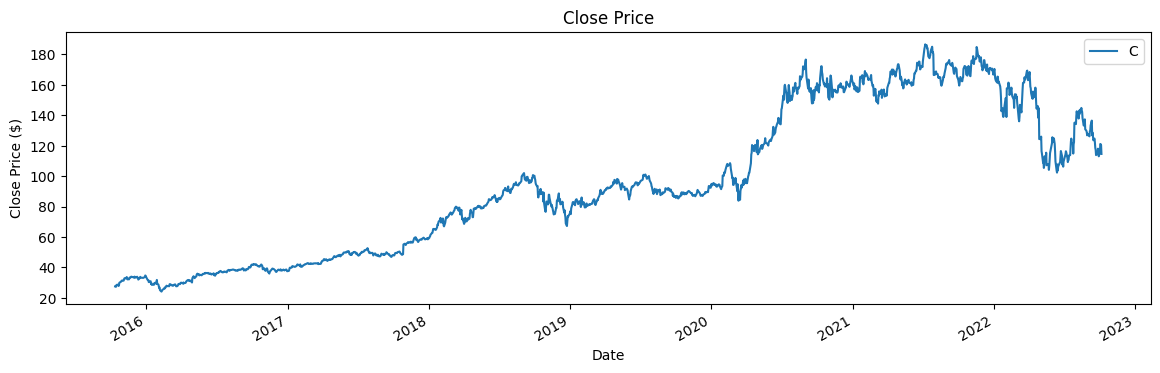

In [34]:
# Plotting close price 
stock_data['Close'].plot(figsize=(14,4), legend=True)
plt.legend('Close Price')
plt.title('Close Price')
plt.ylabel('Close Price ($)')
plt.show()

In [5]:
# Scale the data using the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(np.array(stock_data).reshape(-1,1))

In [7]:
day_to_use = 30
x_train, y_train = [], []
for i in range(day_to_use, len(scaled)):
    x_train.append(scaled[i-day_to_use:i])
    y_train.append(scaled[i])

In [9]:
# Set train_size and test_size
train_size = math.ceil(len(stock_data)*0.8)
test_size = len(scaled) - train_size

In [10]:
# Splitting data between train and test
sd_train, sd_test = scaled[0:train_size,:], scaled[train_size:len(scaled),:1]

In [11]:
# Reshaping data to fit into LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [13]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units = 50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(units = 50))
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Training model with adam optimizer and mse
model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')
# Fit the model
model.fit(x_train, y_train, epochs=25, batch_size=16, verbose=1)

Epoch 1/25
109/109 [==============================] - 3s 8ms/step - loss: 0.0097 - accuracy: 0.0012
Epoch 2/25
109/109 [==============================] - 1s 8ms/step - loss: 9.7677e-04 - accuracy: 0.0012
Epoch 3/25
109/109 [==============================] - 1s 8ms/step - loss: 0.0010 - accuracy: 0.0012
Epoch 4/25
109/109 [==============================] - 1s 8ms/step - loss: 8.4550e-04 - accuracy: 0.0012
Epoch 5/25
109/109 [==============================] - 1s 8ms/step - loss: 7.9466e-04 - accuracy: 0.0012
Epoch 6/25
109/109 [==============================] - 1s 8ms/step - loss: 7.2832e-04 - accuracy: 0.0012
Epoch 7/25
109/109 [==============================] - 1s 8ms/step - loss: 6.7514e-04 - accuracy: 0.0012
Epoch 8/25
109/109 [==============================] - 1s 8ms/step - loss: 6.5299e-04 - accuracy: 0.0012
Epoch 9/25
109/109 [==============================] - 1s 8ms/step - loss: 6.1307e-04 - accuracy: 0.0012
Epoch 10/25
109/109 [==============================] - 1s 8ms/step - los

In [15]:
# To create test values
test_data = scaled[train_size-day_to_use:, :]
x_test = []
y_test = stock_data_array[train_size:, :]
for i in range(day_to_use, len(test_data)):
    x_test.append(test_data[i-day_to_use:i])

x_test = np.array(x_test)

In [16]:
# Make predictions on the test set
prediction = model.predict(x_test)

# Scale the data back to its original form
prediction = scaler.inverse_transform(prediction)
y_test = scaler.inverse_transform(y_train)

11/11 [==============================] - 0s 3ms/step


In [17]:
# Calculate the model's accuracy
accuracy = model.evaluate(x_train, y_train, verbose = 0)
print("Accuracy: {:.4f}%".format(accuracy[1]))

Accuracy: 0.0012%


In [19]:
# Shows the value of "Predictions"
train = stock_data[:train_size]
close_pred = stock_data[train_size:]
close_pred['Predictions'] = prediction

C:\Users\GerphozPC\AppData\Local\Temp\ipykernel_10756\2052742909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_pred['Predictions'] = prediction


In [21]:
close_pred

,Close,Predictions
Date,,
2021-05-18 00:00:00-04:00,161.613998,161.244751
2021-05-19 00:00:00-04:00,161.589996,161.359726
2021-05-20 00:00:00-04:00,162.384003,160.570190
2021-05-21 00:00:00-04:00,160.154007,160.683197
2021-05-24 00:00:00-04:00,162.249496,159.856018
...,...,...
2022-10-03 00:00:00-04:00,115.879997,114.280327
2022-10-04 00:00:00-04:00,121.089996,114.424156
2022-10-05 00:00:00-04:00,120.949997,117.770737


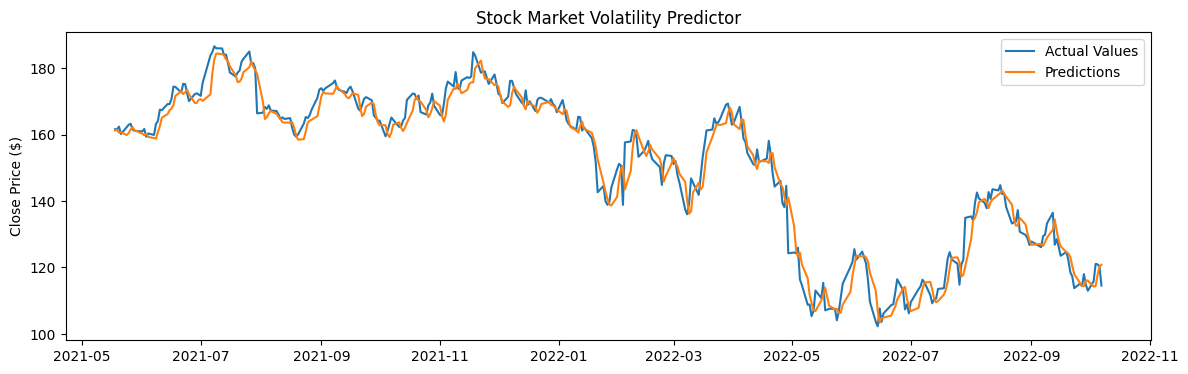

In [35]:
# Plot to all data
plt.figure(figsize=(14,4))
plt.title('Stock Market Volatility Predictor')
plt.ylabel('Close Price ($)')
plt.plot(close_pred[['Close', 'Predictions']])
plt.legend(['Actual Values', 'Predictions'])
plt.show()

In [22]:
# Test predict will predict the next values
testPredict = model.predict(x_test)
testPredict = scaler.inverse_transform(testPredict)

11/11 [==============================] - 0s 3ms/step


In [23]:
# predict the next 10 days
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
next_val = next_val.flatten()
print("Next 10 Days stock price:", np.concatenate((last_val, next_val), axis=0))


1/1 [==============================] - 0s 403ms/step
Next 10 Days stock price: [120.83113      0.28787905]


In [24]:
# Created to predict the next day's stock market volatility
stock_latest = yf.Ticker(ticker).history(period="1d")
stock_latest = stock_latest[['Close']]

In [25]:
# Scale the data using the MinMaxScaler
stock_latest = scaler.transform(stock_latest)
stock_latest = np.reshape(stock_latest, (stock_latest.shape[0], stock_latest.shape[1], 1))

c:\Users\GerphozPC\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [26]:
# Predicts the next day's value
next_day_predict = model.predict(stock_latest)
next_day_predict = scaler.inverse_transform(next_day_predict)
print("Predicted Close price for next day: ", next_day_predict[0][0])

1/1 [==============================] - 0s 9ms/step
Predicted Close price for next day:  41.307175
